## By: Chetan Sai Borra
UIN: 436000947

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from torchinfo import summary
import matplotlib.pyplot as plt
from timm import create_model
from timm.data import Mixup
import re
from timm.scheduler import CosineLRScheduler

C:\Users\asus\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import random_split
import random
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

### Setting device as Cuda for training

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Using Transformations for encoding to tensor

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [5]:
train_path = "train"
validation_path = "validation"


### Creating The dataset 

In [6]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=validation_path, transform=transform)


### Spliting Validation into validation and testing in 80:20 ratio

In [7]:
val_size = int(0.8 * len(val_dataset))
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

### Creating the dataloder for training 

In [8]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Summary of dataset sizes
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 4900
Validation samples: 588
Test samples: 147


### Function to plot the graphs from the logs

In [9]:
def plot_loss(log_file_path):
    epochs = []
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    log_pattern = r"Epoch (\d+)/\d+, Train Loss: ([\d.]+), Train Acc: ([\d.]+), Val Loss: ([\d.]+), Val Acc: ([\d.]+)"

    with open(log_file_path, 'r') as f:
        for line in f:
            match = re.search(log_pattern, line)
            if match:
                epoch = int(match.group(1))
                train_loss = float(match.group(2))
                train_acc = float(match.group(3))
                val_loss = float(match.group(4))
                val_acc = float(match.group(5))
    
                epochs.append(epoch)
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    
    ax[0].plot(epochs, train_losses, label='Train Loss', color='blue')
    ax[0].plot(epochs, val_losses, label='Validation Loss', color='red')
    ax[0].set_title('Losses over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    ax[1].plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
    ax[1].set_title('Accuracy over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()


### Function for checking the images and dataloder 

In [10]:
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1: 
        axes = [axes]
    for img, label, ax in zip(images, labels, axes):
        img = img.permute(1, 2, 0).numpy()  
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  
        img = img.clip(0, 1) 
        ax.imshow(img)
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.show()


### Verifying the images and labels

Sample Labels: ['cat17 LowRise', 'cat22 Canopy', 'cat10 StripMall', 'cat18 MidRise', 'cat07 MasAptMotel', 'cat18 MidRise', 'cat19 HighRise', 'cat22 Canopy', 'cat07 MasAptMotel', 'cat19 HighRise']


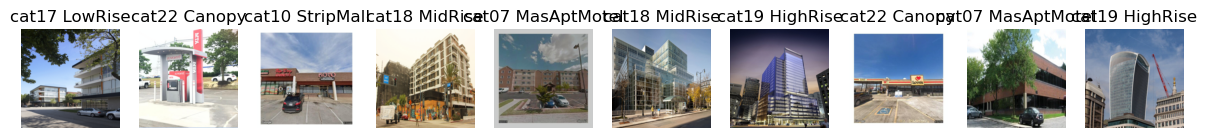

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

class_names = train_dataset.classes  

print("Sample Labels:", [class_names[label] for label in labels[:10]]) 
show_images(images[:10], labels[:10], class_names)

### Verifying the shape of input data

In [12]:
for image, label in train_loader:
    print(f"Label range in train_loader: {label.min()} to {label.max()}")
    print(image.shape)
    print(label.shape)
    break


Label range in train_loader: 0 to 6
torch.Size([128, 3, 224, 224])
torch.Size([128])


# Building and Implementing the DeiT Model

## Introduction
The **Data-efficient Image Transformer (DeiT)** is a vision transformer model that offers competitive performance in image classification tasks with fewer labeled data. Unlike convolutional neural networks (CNNs), DeiT directly processes image patches as input, leveraging the self-attention mechanism for feature extraction.

## Key Features
- **Patch Embeddings**: Images are divided into fixed-size patches, which are linearly projected into embedding space.
- **Self-Attention**: Captures long-range dependencies and relationships between image patches.
- **Class Token**: Represents the global image representation, used for classification.
- **Data Efficiency**: Optimized training strategies allow effective learning with less labeled data.


In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=192):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2)  # [B, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

In [14]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.3, qkv_bias=True):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.query = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.key = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.value = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        q = self.query(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # [B, heads, N, head_dim]
        k = self.key(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).permute(0, 2, 1, 3).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x


In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=5.0, dropout=0.3):
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [20]:
pretrained_deit = create_model('deit_tiny_patch16_224', pretrained=True)

In [21]:
class DeiTTiny(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=7, embed_dim=192, depth=8, num_heads=6, mlp_ratio=5.0, dropout=0.3):
        super(DeiTTiny, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels=3, embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            pretrained_deit.blocks[i] if i < 6 else
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for i in range(depth)
        ])

        for i in range(2):  # Freezing first 2 blocks
            for param in self.blocks[i].parameters():
                param.requires_grad = False

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, 256)
        self.norm1 = nn.LayerNorm(256)
        self.head1 = nn.Linear(256, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.LayerNorm):
                nn.init.constant_(module.bias, 0)
                nn.init.constant_(module.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_token, x), dim=1)  # [B, 1 + num_patches, embed_dim]
        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_output = x[:, 0]  # Extract CLS token
        x = self.head(cls_output)
        x = self.norm1(x)
        x = self.head1(x)
        return x

In [22]:
model = DeiTTiny(num_classes=7)

## Model Summary

In [23]:
summary(model, input_shape= (128, 3, 224, 224))

Layer (type:depth-idx)                        Param #
DeiTTiny                                      38,016
├─PatchEmbedding: 1-1                         --
│    └─Conv2d: 2-1                            147,648
├─Dropout: 1-2                                --
├─ModuleList: 1-3                             --
│    └─Block: 2-2                             --
│    │    └─LayerNorm: 3-1                    (384)
│    │    └─Attention: 3-2                    (148,224)
│    │    └─Identity: 3-3                     --
│    │    └─Identity: 3-4                     --
│    │    └─LayerNorm: 3-5                    (384)
│    │    └─Mlp: 3-6                          (295,872)
│    │    └─Identity: 3-7                     --
│    │    └─Identity: 3-8                     --
│    └─Block: 2-3                             --
│    │    └─LayerNorm: 3-9                    (384)
│    │    └─Attention: 3-10                   (148,224)
│    │    └─Identity: 3-11                    --
│    │    └─Identity: 3-1

In [24]:

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Log details
log_file = os.path.join(save_dir, "training_log21.txt")


In [25]:
def mixup_data(x, y, alpha=0.5):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 0.5
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

use_mixup = True

In [26]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
num_epochs = 200
scheduler = CosineLRScheduler(
    optimizer, t_initial=num_epochs, lr_min=1e-6, warmup_t=5, warmup_lr_init=1e-6
)

In [27]:
for epoch in range(num_epochs):
    
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        if use_mixup:
            inputs, y_a, y_b, lam = mixup_data(inputs, targets)

        outputs = model(inputs)

        if use_mixup:
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            
        #loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_train += (predictions == targets).sum().item()
        total_train += targets.size(0)

    train_acc = correct_train / total_train
    train_loss /= len(train_loader)

    scheduler.step(epoch)

    # Validation Phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            correct_val += (predictions == targets).sum().item()
            total_val += targets.size(0)

    val_acc = correct_val / total_val
    val_loss /= len(val_loader)

    # Log and print details
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    with open(log_file, "a") as f:
        f.write(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

    # Save model
    torch.save(model.state_dict(), "deit_from_scratch21.pth")

Epoch 1/200, Train Loss: 1.9983, Train Acc: 0.1296, Val Loss: 1.9591, Val Acc: 0.1259


Epoch 2/200, Train Loss: 1.9695, Train Acc: 0.1480, Val Loss: 1.9229, Val Acc: 0.1616


Epoch 3/200, Train Loss: 1.9227, Train Acc: 0.1927, Val Loss: 1.8453, Val Acc: 0.2551


Epoch 4/200, Train Loss: 1.8858, Train Acc: 0.2073, Val Loss: 1.8510, Val Acc: 0.2347


Epoch 5/200, Train Loss: 1.8397, Train Acc: 0.2149, Val Loss: 1.6806, Val Acc: 0.3401


Epoch 6/200, Train Loss: 1.8028, Train Acc: 0.2318, Val Loss: 1.8450, Val Acc: 0.2840


Epoch 7/200, Train Loss: 1.8241, Train Acc: 0.2141, Val Loss: 1.7491, Val Acc: 0.2738


Epoch 8/200, Train Loss: 1.7565, Train Acc: 0.2363, Val Loss: 1.6388, Val Acc: 0.3367


Epoch 9/200, Train Loss: 1.7291, Train Acc: 0.2569, Val Loss: 1.6319, Val Acc: 0.3486


Epoch 10/200, Train Loss: 1.7021, Train Acc: 0.2643, Val Loss: 1.4989, Val Acc: 0.3997


Epoch 11/200, Train Loss: 1.6690, Train Acc: 0.2380, Val Loss: 1.5553, Val Acc: 0.3878


Epoch 12/200, Train Loss: 1.6372, Train Acc: 0.3210, Val Loss: 1.4963, Val Acc: 0.4014


Epoch 13/200, Train Loss: 1.6553, Train Acc: 0.2943, Val Loss: 1.5377, Val Acc: 0.4320


Epoch 14/200, Train Loss: 1.6185, Train Acc: 0.2602, Val Loss: 1.4527, Val Acc: 0.4439


Epoch 15/200, Train Loss: 1.5786, Train Acc: 0.3057, Val Loss: 1.3970, Val Acc: 0.4473


Epoch 16/200, Train Loss: 1.6528, Train Acc: 0.2957, Val Loss: 1.3971, Val Acc: 0.4796


Epoch 17/200, Train Loss: 1.5689, Train Acc: 0.3392, Val Loss: 1.4435, Val Acc: 0.4337


Epoch 18/200, Train Loss: 1.5796, Train Acc: 0.3284, Val Loss: 1.4491, Val Acc: 0.4558


Epoch 19/200, Train Loss: 1.5717, Train Acc: 0.2851, Val Loss: 1.4061, Val Acc: 0.4388


Epoch 20/200, Train Loss: 1.5481, Train Acc: 0.3329, Val Loss: 1.3440, Val Acc: 0.5034


Epoch 21/200, Train Loss: 1.5140, Train Acc: 0.3429, Val Loss: 1.3690, Val Acc: 0.4507


Epoch 22/200, Train Loss: 1.4765, Train Acc: 0.3547, Val Loss: 1.3320, Val Acc: 0.4898


Epoch 23/200, Train Loss: 1.4733, Train Acc: 0.3280, Val Loss: 1.2969, Val Acc: 0.4983


Epoch 24/200, Train Loss: 1.4996, Train Acc: 0.2776, Val Loss: 1.2887, Val Acc: 0.5272


Epoch 25/200, Train Loss: 1.4683, Train Acc: 0.3347, Val Loss: 1.2598, Val Acc: 0.5493


Epoch 26/200, Train Loss: 1.4566, Train Acc: 0.3241, Val Loss: 1.2411, Val Acc: 0.5255


Epoch 27/200, Train Loss: 1.4535, Train Acc: 0.3263, Val Loss: 1.2223, Val Acc: 0.5408


Epoch 28/200, Train Loss: 1.4377, Train Acc: 0.3612, Val Loss: 1.2214, Val Acc: 0.5442


Epoch 29/200, Train Loss: 1.4048, Train Acc: 0.3200, Val Loss: 1.2490, Val Acc: 0.5306


Epoch 30/200, Train Loss: 1.4014, Train Acc: 0.3416, Val Loss: 1.2100, Val Acc: 0.5782


Epoch 31/200, Train Loss: 1.4001, Train Acc: 0.3676, Val Loss: 1.2818, Val Acc: 0.5272


Epoch 32/200, Train Loss: 1.3317, Train Acc: 0.4378, Val Loss: 1.1463, Val Acc: 0.5782


Epoch 33/200, Train Loss: 1.4739, Train Acc: 0.4043, Val Loss: 1.2480, Val Acc: 0.5510


Epoch 34/200, Train Loss: 1.3181, Train Acc: 0.4041, Val Loss: 1.1577, Val Acc: 0.5935


Epoch 35/200, Train Loss: 1.3693, Train Acc: 0.3661, Val Loss: 1.2802, Val Acc: 0.5255


Epoch 36/200, Train Loss: 1.3257, Train Acc: 0.3584, Val Loss: 1.1727, Val Acc: 0.5697


Epoch 37/200, Train Loss: 1.3799, Train Acc: 0.3476, Val Loss: 1.1742, Val Acc: 0.5782


Epoch 38/200, Train Loss: 1.4322, Train Acc: 0.3310, Val Loss: 1.1639, Val Acc: 0.5714


Epoch 39/200, Train Loss: 1.3876, Train Acc: 0.3357, Val Loss: 1.1637, Val Acc: 0.5799


Epoch 40/200, Train Loss: 1.2976, Train Acc: 0.3941, Val Loss: 1.2046, Val Acc: 0.5561


Epoch 41/200, Train Loss: 1.3257, Train Acc: 0.4059, Val Loss: 1.0809, Val Acc: 0.5901


Epoch 42/200, Train Loss: 1.3024, Train Acc: 0.3445, Val Loss: 1.1138, Val Acc: 0.5918


Epoch 43/200, Train Loss: 1.3057, Train Acc: 0.3990, Val Loss: 1.1437, Val Acc: 0.5714


Epoch 44/200, Train Loss: 1.2551, Train Acc: 0.3331, Val Loss: 1.1062, Val Acc: 0.5969


Epoch 45/200, Train Loss: 1.2803, Train Acc: 0.4108, Val Loss: 1.1424, Val Acc: 0.5799


Epoch 46/200, Train Loss: 1.2208, Train Acc: 0.4435, Val Loss: 1.0612, Val Acc: 0.6190


Epoch 47/200, Train Loss: 1.2162, Train Acc: 0.4500, Val Loss: 1.0902, Val Acc: 0.5918


Epoch 48/200, Train Loss: 1.2144, Train Acc: 0.3398, Val Loss: 1.1124, Val Acc: 0.6276


Epoch 49/200, Train Loss: 1.2362, Train Acc: 0.4055, Val Loss: 1.0609, Val Acc: 0.6259


Epoch 50/200, Train Loss: 1.1130, Train Acc: 0.3553, Val Loss: 1.1486, Val Acc: 0.6071


Epoch 51/200, Train Loss: 1.2447, Train Acc: 0.4112, Val Loss: 1.0675, Val Acc: 0.6105


Epoch 52/200, Train Loss: 1.2514, Train Acc: 0.4155, Val Loss: 1.1198, Val Acc: 0.5867


Epoch 53/200, Train Loss: 1.2255, Train Acc: 0.3961, Val Loss: 1.0354, Val Acc: 0.6276


Epoch 54/200, Train Loss: 1.2566, Train Acc: 0.3945, Val Loss: 1.1297, Val Acc: 0.5969


Epoch 55/200, Train Loss: 1.1143, Train Acc: 0.3778, Val Loss: 1.3189, Val Acc: 0.5680


Epoch 56/200, Train Loss: 1.1791, Train Acc: 0.5096, Val Loss: 1.1226, Val Acc: 0.5850


Epoch 57/200, Train Loss: 1.2811, Train Acc: 0.4033, Val Loss: 1.0568, Val Acc: 0.6463


Epoch 58/200, Train Loss: 1.1800, Train Acc: 0.4504, Val Loss: 1.0822, Val Acc: 0.6207


Epoch 59/200, Train Loss: 1.2819, Train Acc: 0.3663, Val Loss: 1.1299, Val Acc: 0.5952


Epoch 60/200, Train Loss: 1.2010, Train Acc: 0.5206, Val Loss: 1.0827, Val Acc: 0.6054


Epoch 61/200, Train Loss: 1.1385, Train Acc: 0.4861, Val Loss: 1.0591, Val Acc: 0.6361


Epoch 62/200, Train Loss: 1.1847, Train Acc: 0.4300, Val Loss: 1.0809, Val Acc: 0.6190


Epoch 63/200, Train Loss: 1.1144, Train Acc: 0.5145, Val Loss: 1.1398, Val Acc: 0.6293


Epoch 64/200, Train Loss: 1.0385, Train Acc: 0.3696, Val Loss: 1.0958, Val Acc: 0.6378


Epoch 65/200, Train Loss: 1.1015, Train Acc: 0.4594, Val Loss: 1.0308, Val Acc: 0.6327


Epoch 66/200, Train Loss: 1.1846, Train Acc: 0.4680, Val Loss: 1.0882, Val Acc: 0.6241


Epoch 67/200, Train Loss: 1.0785, Train Acc: 0.4816, Val Loss: 1.0260, Val Acc: 0.6276


Epoch 68/200, Train Loss: 1.1032, Train Acc: 0.4212, Val Loss: 1.0543, Val Acc: 0.6224


Epoch 69/200, Train Loss: 1.0255, Train Acc: 0.4745, Val Loss: 1.1057, Val Acc: 0.6224


Epoch 70/200, Train Loss: 1.0698, Train Acc: 0.3918, Val Loss: 1.1040, Val Acc: 0.6344


Epoch 71/200, Train Loss: 1.0912, Train Acc: 0.4990, Val Loss: 1.1983, Val Acc: 0.5731


Epoch 72/200, Train Loss: 1.1072, Train Acc: 0.4520, Val Loss: 1.1080, Val Acc: 0.6105


Epoch 73/200, Train Loss: 0.9964, Train Acc: 0.4508, Val Loss: 1.1064, Val Acc: 0.6429


Epoch 74/200, Train Loss: 1.0278, Train Acc: 0.4902, Val Loss: 1.1160, Val Acc: 0.6259


Epoch 75/200, Train Loss: 1.1423, Train Acc: 0.4467, Val Loss: 1.0484, Val Acc: 0.6599


Epoch 76/200, Train Loss: 1.1015, Train Acc: 0.4716, Val Loss: 0.9972, Val Acc: 0.6667


Epoch 77/200, Train Loss: 0.9547, Train Acc: 0.5300, Val Loss: 1.0607, Val Acc: 0.6361


Epoch 78/200, Train Loss: 1.0287, Train Acc: 0.4802, Val Loss: 1.1839, Val Acc: 0.6395


Epoch 79/200, Train Loss: 1.0646, Train Acc: 0.4108, Val Loss: 1.0305, Val Acc: 0.6769


Epoch 80/200, Train Loss: 0.9495, Train Acc: 0.4702, Val Loss: 1.0133, Val Acc: 0.6548


Epoch 81/200, Train Loss: 1.1555, Train Acc: 0.3910, Val Loss: 1.0805, Val Acc: 0.6548


Epoch 82/200, Train Loss: 1.1082, Train Acc: 0.4614, Val Loss: 1.0492, Val Acc: 0.6480


Epoch 83/200, Train Loss: 1.0703, Train Acc: 0.4041, Val Loss: 1.0013, Val Acc: 0.6480


Epoch 84/200, Train Loss: 1.0367, Train Acc: 0.5441, Val Loss: 1.0238, Val Acc: 0.6718


Epoch 85/200, Train Loss: 0.8718, Train Acc: 0.4320, Val Loss: 0.9997, Val Acc: 0.6616


Epoch 86/200, Train Loss: 1.0267, Train Acc: 0.4561, Val Loss: 1.0232, Val Acc: 0.6480


Epoch 87/200, Train Loss: 1.1168, Train Acc: 0.4735, Val Loss: 1.0070, Val Acc: 0.6820


Epoch 88/200, Train Loss: 0.9930, Train Acc: 0.4633, Val Loss: 1.0123, Val Acc: 0.6616


Epoch 89/200, Train Loss: 1.0017, Train Acc: 0.4180, Val Loss: 1.0343, Val Acc: 0.6633


Epoch 90/200, Train Loss: 0.9509, Train Acc: 0.4912, Val Loss: 1.0456, Val Acc: 0.6548


Epoch 91/200, Train Loss: 0.8999, Train Acc: 0.5886, Val Loss: 0.9739, Val Acc: 0.6854


Epoch 92/200, Train Loss: 0.7893, Train Acc: 0.5114, Val Loss: 1.0484, Val Acc: 0.6548


Epoch 93/200, Train Loss: 0.9238, Train Acc: 0.4376, Val Loss: 1.0966, Val Acc: 0.6344


Epoch 94/200, Train Loss: 1.0501, Train Acc: 0.4986, Val Loss: 0.9609, Val Acc: 0.6922


Epoch 95/200, Train Loss: 1.0276, Train Acc: 0.5296, Val Loss: 1.0218, Val Acc: 0.6718


Epoch 96/200, Train Loss: 0.9530, Train Acc: 0.4773, Val Loss: 0.9905, Val Acc: 0.6820


Epoch 97/200, Train Loss: 0.9198, Train Acc: 0.5624, Val Loss: 1.1285, Val Acc: 0.6173


Epoch 98/200, Train Loss: 0.8389, Train Acc: 0.5435, Val Loss: 0.9610, Val Acc: 0.6769


Epoch 99/200, Train Loss: 0.9682, Train Acc: 0.4833, Val Loss: 1.0901, Val Acc: 0.6548


Epoch 100/200, Train Loss: 0.9759, Train Acc: 0.5447, Val Loss: 1.0118, Val Acc: 0.6752


Epoch 101/200, Train Loss: 0.9614, Train Acc: 0.4045, Val Loss: 0.9838, Val Acc: 0.6769


Epoch 102/200, Train Loss: 0.8072, Train Acc: 0.5400, Val Loss: 0.9666, Val Acc: 0.6956


Epoch 103/200, Train Loss: 0.9032, Train Acc: 0.6159, Val Loss: 0.9875, Val Acc: 0.6752


Epoch 104/200, Train Loss: 0.9949, Train Acc: 0.4457, Val Loss: 1.0805, Val Acc: 0.6684


Epoch 105/200, Train Loss: 0.8478, Train Acc: 0.5788, Val Loss: 0.9919, Val Acc: 0.6888


Epoch 106/200, Train Loss: 0.8648, Train Acc: 0.5498, Val Loss: 1.0291, Val Acc: 0.6633


Epoch 107/200, Train Loss: 0.8959, Train Acc: 0.5122, Val Loss: 1.0361, Val Acc: 0.6633


Epoch 108/200, Train Loss: 0.8735, Train Acc: 0.5847, Val Loss: 0.9836, Val Acc: 0.6905


Epoch 109/200, Train Loss: 0.9172, Train Acc: 0.5316, Val Loss: 0.9701, Val Acc: 0.7058


Epoch 110/200, Train Loss: 0.9036, Train Acc: 0.4394, Val Loss: 1.0207, Val Acc: 0.6769


Epoch 111/200, Train Loss: 0.8940, Train Acc: 0.6235, Val Loss: 1.0235, Val Acc: 0.6854


Epoch 112/200, Train Loss: 0.8611, Train Acc: 0.4529, Val Loss: 0.9766, Val Acc: 0.6956


Epoch 113/200, Train Loss: 0.7755, Train Acc: 0.4329, Val Loss: 1.0426, Val Acc: 0.6667


Epoch 114/200, Train Loss: 0.7621, Train Acc: 0.5500, Val Loss: 0.9928, Val Acc: 0.6990


Epoch 115/200, Train Loss: 0.8150, Train Acc: 0.4563, Val Loss: 1.0027, Val Acc: 0.6990


Epoch 116/200, Train Loss: 0.9170, Train Acc: 0.5602, Val Loss: 1.0402, Val Acc: 0.6701


Epoch 117/200, Train Loss: 0.9803, Train Acc: 0.4873, Val Loss: 0.9644, Val Acc: 0.7092


Epoch 118/200, Train Loss: 0.8692, Train Acc: 0.5433, Val Loss: 0.9982, Val Acc: 0.6820


Epoch 119/200, Train Loss: 0.6918, Train Acc: 0.6257, Val Loss: 1.0232, Val Acc: 0.6956


Epoch 120/200, Train Loss: 0.8186, Train Acc: 0.6324, Val Loss: 1.0011, Val Acc: 0.6854


Epoch 121/200, Train Loss: 0.6947, Train Acc: 0.5563, Val Loss: 1.0195, Val Acc: 0.6837


Epoch 122/200, Train Loss: 0.9543, Train Acc: 0.5259, Val Loss: 1.0237, Val Acc: 0.6990


Epoch 123/200, Train Loss: 0.8486, Train Acc: 0.6200, Val Loss: 1.0040, Val Acc: 0.7007


Epoch 124/200, Train Loss: 0.7083, Train Acc: 0.5886, Val Loss: 0.9701, Val Acc: 0.7279


Epoch 125/200, Train Loss: 0.8320, Train Acc: 0.5573, Val Loss: 1.0020, Val Acc: 0.7075


Epoch 126/200, Train Loss: 0.8001, Train Acc: 0.5676, Val Loss: 1.0058, Val Acc: 0.6820


Epoch 127/200, Train Loss: 0.8713, Train Acc: 0.4631, Val Loss: 0.9648, Val Acc: 0.7041


Epoch 128/200, Train Loss: 0.7339, Train Acc: 0.5986, Val Loss: 1.0331, Val Acc: 0.6990


Epoch 129/200, Train Loss: 0.8062, Train Acc: 0.5420, Val Loss: 1.0211, Val Acc: 0.6871


Epoch 130/200, Train Loss: 0.7193, Train Acc: 0.5057, Val Loss: 0.9056, Val Acc: 0.7449


Epoch 131/200, Train Loss: 0.7871, Train Acc: 0.5010, Val Loss: 0.9600, Val Acc: 0.7041


Epoch 132/200, Train Loss: 0.8118, Train Acc: 0.5688, Val Loss: 0.9672, Val Acc: 0.7058


Epoch 133/200, Train Loss: 0.8538, Train Acc: 0.5745, Val Loss: 0.9887, Val Acc: 0.7058


Epoch 134/200, Train Loss: 0.8233, Train Acc: 0.6400, Val Loss: 0.9510, Val Acc: 0.7058


Epoch 135/200, Train Loss: 0.8087, Train Acc: 0.5808, Val Loss: 0.9794, Val Acc: 0.7041


Epoch 136/200, Train Loss: 0.6381, Train Acc: 0.6041, Val Loss: 0.9545, Val Acc: 0.7041


Epoch 137/200, Train Loss: 0.7798, Train Acc: 0.6388, Val Loss: 0.9542, Val Acc: 0.7058


Epoch 138/200, Train Loss: 0.8820, Train Acc: 0.4959, Val Loss: 0.9263, Val Acc: 0.7177


Epoch 139/200, Train Loss: 0.7331, Train Acc: 0.5239, Val Loss: 0.9582, Val Acc: 0.6939


Epoch 140/200, Train Loss: 0.8284, Train Acc: 0.5786, Val Loss: 0.9985, Val Acc: 0.6973


Epoch 141/200, Train Loss: 0.6420, Train Acc: 0.5857, Val Loss: 0.9841, Val Acc: 0.7024


Epoch 142/200, Train Loss: 0.6695, Train Acc: 0.5382, Val Loss: 0.9899, Val Acc: 0.7109


Epoch 143/200, Train Loss: 0.6757, Train Acc: 0.6584, Val Loss: 0.9676, Val Acc: 0.7058


Epoch 144/200, Train Loss: 0.7568, Train Acc: 0.4782, Val Loss: 0.9125, Val Acc: 0.7296


Epoch 145/200, Train Loss: 0.7075, Train Acc: 0.6296, Val Loss: 0.9849, Val Acc: 0.7024


Epoch 146/200, Train Loss: 0.6845, Train Acc: 0.6273, Val Loss: 1.0039, Val Acc: 0.7092


Epoch 147/200, Train Loss: 0.8320, Train Acc: 0.5567, Val Loss: 0.9506, Val Acc: 0.7245


Epoch 148/200, Train Loss: 0.6852, Train Acc: 0.5451, Val Loss: 0.9492, Val Acc: 0.7177


Epoch 149/200, Train Loss: 0.7315, Train Acc: 0.6114, Val Loss: 0.9751, Val Acc: 0.7194


Epoch 150/200, Train Loss: 0.7282, Train Acc: 0.5761, Val Loss: 0.9674, Val Acc: 0.7075


Epoch 151/200, Train Loss: 0.6567, Train Acc: 0.4792, Val Loss: 0.9261, Val Acc: 0.7211


Epoch 152/200, Train Loss: 0.7687, Train Acc: 0.5092, Val Loss: 0.9359, Val Acc: 0.7228


Epoch 153/200, Train Loss: 0.8012, Train Acc: 0.4394, Val Loss: 0.9559, Val Acc: 0.7177


Epoch 154/200, Train Loss: 0.5790, Train Acc: 0.6316, Val Loss: 0.9393, Val Acc: 0.7194


Epoch 155/200, Train Loss: 0.8018, Train Acc: 0.5661, Val Loss: 0.9774, Val Acc: 0.6990


Epoch 156/200, Train Loss: 0.8194, Train Acc: 0.5245, Val Loss: 0.9867, Val Acc: 0.6871


Epoch 157/200, Train Loss: 0.9119, Train Acc: 0.5978, Val Loss: 0.9055, Val Acc: 0.7262


Epoch 158/200, Train Loss: 0.7129, Train Acc: 0.4871, Val Loss: 0.9429, Val Acc: 0.7126


Epoch 159/200, Train Loss: 0.5966, Train Acc: 0.5618, Val Loss: 0.9390, Val Acc: 0.7262


Epoch 160/200, Train Loss: 0.6674, Train Acc: 0.4969, Val Loss: 0.9398, Val Acc: 0.7160


Epoch 161/200, Train Loss: 0.5829, Train Acc: 0.5276, Val Loss: 0.9565, Val Acc: 0.7245


Epoch 162/200, Train Loss: 0.6508, Train Acc: 0.4235, Val Loss: 0.9371, Val Acc: 0.7143


Epoch 163/200, Train Loss: 0.7475, Train Acc: 0.4686, Val Loss: 0.9413, Val Acc: 0.7177


Epoch 164/200, Train Loss: 0.6794, Train Acc: 0.5522, Val Loss: 0.9657, Val Acc: 0.7262


Epoch 165/200, Train Loss: 0.7855, Train Acc: 0.5261, Val Loss: 0.9619, Val Acc: 0.7177


Epoch 166/200, Train Loss: 0.6414, Train Acc: 0.5888, Val Loss: 0.9570, Val Acc: 0.7279


Epoch 167/200, Train Loss: 0.6199, Train Acc: 0.5863, Val Loss: 0.9516, Val Acc: 0.7194


Epoch 168/200, Train Loss: 0.7227, Train Acc: 0.5088, Val Loss: 0.9436, Val Acc: 0.7194


Epoch 169/200, Train Loss: 0.8512, Train Acc: 0.5224, Val Loss: 0.9494, Val Acc: 0.7177


Epoch 170/200, Train Loss: 0.7080, Train Acc: 0.6282, Val Loss: 0.9310, Val Acc: 0.7194


Epoch 171/200, Train Loss: 0.7081, Train Acc: 0.6327, Val Loss: 0.9510, Val Acc: 0.7177


Epoch 172/200, Train Loss: 0.6616, Train Acc: 0.5057, Val Loss: 0.9384, Val Acc: 0.7143


Epoch 173/200, Train Loss: 0.7134, Train Acc: 0.5265, Val Loss: 0.9500, Val Acc: 0.7228


Epoch 174/200, Train Loss: 0.6793, Train Acc: 0.5498, Val Loss: 0.9322, Val Acc: 0.7194


Epoch 175/200, Train Loss: 0.6731, Train Acc: 0.4571, Val Loss: 0.9369, Val Acc: 0.7228


Epoch 176/200, Train Loss: 0.7273, Train Acc: 0.5922, Val Loss: 0.9351, Val Acc: 0.7211


Epoch 177/200, Train Loss: 0.6738, Train Acc: 0.4912, Val Loss: 0.9708, Val Acc: 0.7109


Epoch 178/200, Train Loss: 0.7042, Train Acc: 0.6094, Val Loss: 0.9226, Val Acc: 0.7228


Epoch 179/200, Train Loss: 0.7298, Train Acc: 0.5557, Val Loss: 0.9271, Val Acc: 0.7211


Epoch 180/200, Train Loss: 0.7437, Train Acc: 0.6782, Val Loss: 0.9513, Val Acc: 0.7143


Epoch 181/200, Train Loss: 0.7646, Train Acc: 0.5898, Val Loss: 0.9418, Val Acc: 0.7160


Epoch 182/200, Train Loss: 0.7004, Train Acc: 0.5378, Val Loss: 0.9325, Val Acc: 0.7211


Epoch 183/200, Train Loss: 0.6263, Train Acc: 0.4980, Val Loss: 0.9592, Val Acc: 0.7177


Epoch 184/200, Train Loss: 0.7304, Train Acc: 0.4780, Val Loss: 0.9443, Val Acc: 0.7126


Epoch 185/200, Train Loss: 0.6632, Train Acc: 0.5743, Val Loss: 0.9386, Val Acc: 0.7143


Epoch 186/200, Train Loss: 0.6613, Train Acc: 0.5292, Val Loss: 0.9226, Val Acc: 0.7245


Epoch 187/200, Train Loss: 0.7479, Train Acc: 0.5741, Val Loss: 0.9422, Val Acc: 0.7228


Epoch 188/200, Train Loss: 0.6282, Train Acc: 0.4612, Val Loss: 0.9493, Val Acc: 0.7177


Epoch 189/200, Train Loss: 0.8587, Train Acc: 0.5388, Val Loss: 0.9378, Val Acc: 0.7211


Epoch 190/200, Train Loss: 0.5629, Train Acc: 0.5557, Val Loss: 0.9457, Val Acc: 0.7211


Epoch 191/200, Train Loss: 0.8215, Train Acc: 0.5357, Val Loss: 0.9442, Val Acc: 0.7109


Epoch 192/200, Train Loss: 0.7241, Train Acc: 0.4682, Val Loss: 0.9371, Val Acc: 0.7109


Epoch 193/200, Train Loss: 0.6457, Train Acc: 0.5451, Val Loss: 0.9370, Val Acc: 0.7211


Epoch 194/200, Train Loss: 0.7655, Train Acc: 0.5198, Val Loss: 0.9235, Val Acc: 0.7245


Epoch 195/200, Train Loss: 0.6846, Train Acc: 0.6455, Val Loss: 0.9463, Val Acc: 0.7109


Epoch 196/200, Train Loss: 0.6941, Train Acc: 0.4994, Val Loss: 0.9248, Val Acc: 0.7143


Epoch 197/200, Train Loss: 0.7977, Train Acc: 0.5947, Val Loss: 0.9586, Val Acc: 0.7143


Epoch 198/200, Train Loss: 0.6741, Train Acc: 0.5182, Val Loss: 0.9604, Val Acc: 0.7092


Epoch 199/200, Train Loss: 0.7671, Train Acc: 0.5649, Val Loss: 0.9553, Val Acc: 0.7126


Epoch 200/200, Train Loss: 0.6903, Train Acc: 0.4641, Val Loss: 0.9449, Val Acc: 0.7143


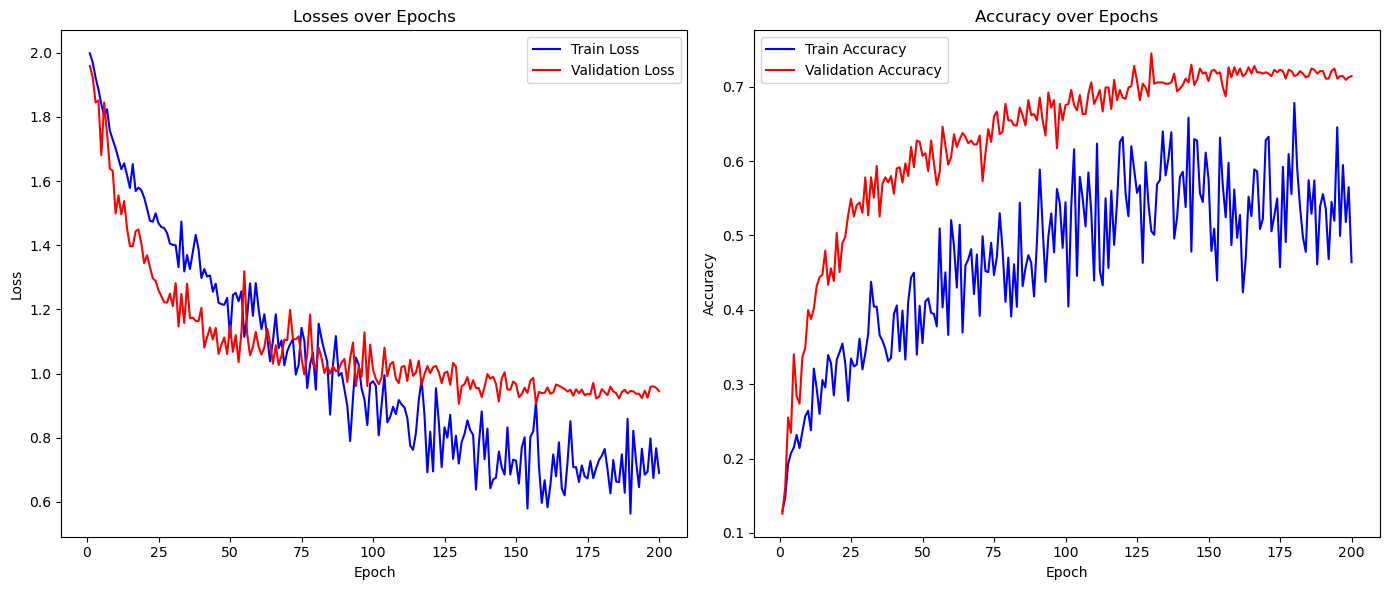

In [28]:
log_file_path = 'saved_models/training_log21.txt'

plot_loss(log_file_path)

# Test results

In [30]:

# Function to evaluate the model and generate a classification report
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)

            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

    
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    
class_names = ["cat07 MasAptMotel", "cat10 StripMall", "cat17 LowRise", "cat18 MidRise", "cat19 HighRise", "cat21 MetalBldg", "cat22 Canopy"]  # Replace with actual class names
evaluate_model(model, test_loader, device, class_names)


Classification Report:
                   precision    recall  f1-score   support

cat07 MasAptMotel       0.72      0.72      0.72        18
  cat10 StripMall       0.92      0.88      0.90        25
    cat17 LowRise       0.61      0.71      0.65        24
    cat18 MidRise       0.76      0.68      0.72        19
   cat19 HighRise       0.67      0.71      0.69        17
  cat21 MetalBldg       0.79      0.70      0.75        27
     cat22 Canopy       0.83      0.88      0.86        17

         accuracy                           0.76       147
        macro avg       0.76      0.76      0.75       147
     weighted avg       0.76      0.76      0.76       147

Confusion Matrix:
[[13  0  2  0  1  1  1]
 [ 0 22  1  0  0  2  0]
 [ 0  0 17  3  2  0  2]
 [ 2  0  3 13  0  1  0]
 [ 0  0  3  1 12  1  0]
 [ 2  2  1  0  3 19  0]
 [ 1  0  1  0  0  0 15]]
